توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [1]:
## download data
%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [5]:
# function 1
def displacement(img):
  ## To Do
  rows, cols, _ = img.shape
  M = np.float32([[1, 0, 30], [0, 1, 30]])
  img = cv2.warpAffine(img, M, (cols, rows))
  return img

# function 2
def rotation(img):
  ## To Do
  rows, cols, _ = img.shape
  angle = np.random.randint(1, 360)
  M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
  img = cv2.warpAffine(img, M, (cols, rows))
  return img


# function 3
def scaling(img):
  ## To Do
  scale_factor = np.random.uniform(0.5, 1.5)
  img = cv2.resize(img, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)
  return img



# function 4
def Brightness(img):  ## for augmentation
  ## To Do
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  brightness_factor = np.random.uniform(0.5, 1.5)
  hsv[:, :, 2] = np.clip(hsv[:, :, 2] * brightness_factor, 0, 255)
  img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
  return img



# function 5
def bluring(img):# for augmentation
  ## To Do
  kernel_size = np.random.choice([3, 5, 7])
  img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
  return img

# function 6
def gaussian_noise(img):#for augmentation
  ## To Do
  row, col, ch = img.shape
  mean = 0
  var = 10
  sigma = var**0.5
  gauss = np.random.normal(mean, sigma, (row, col, ch))
  img = np.clip(img + gauss, 0, 255).astype(np.uint8)
  return img





In [7]:
class CustomDataset(Dataset):

    def __init__(self,root_dir,dataset_type='training'):
      ## To Do
      self.root_dir = root_dir

      if dataset_type == 'test':
          self.dataset_dir = os.path.join(self.root_dir, 'testing')
      else:
          self.dataset_dir = os.path.join(self.root_dir, 'images', dataset_type)

      self.image_paths = glob.glob(os.path.join(self.dataset_dir, '*.jpg'))
      self.transform = transforms.Compose([
          transforms.ToTensor(),

        ])

    def __getitem__(self,idx):
      ## To Do
      original_img = cv2.imread(self.image_paths[idx])
      original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

      displaced_img = displacement(original_img)
      rotated_img = rotation(original_img)
      scaled_img = scaling(original_img)
      bright_img = Brightness(original_img)
      blurred_img = bluring(original_img)
      noisy_img = gaussian_noise(original_img)

      original_img = self.transform(original_img)
      displaced_img = self.transform(displaced_img)
      rotated_img = self.transform(rotated_img)
      scaled_img = self.transform(scaled_img)
      bright_img = self.transform(bright_img)
      blurred_img = self.transform(blurred_img)
      noisy_img = self.transform(noisy_img)

      return {
          'original': original_img,
          'displaced': displaced_img,
          'rotated': rotated_img,
          'scaled': scaled_img,
          'brightness_adjusted': bright_img,
          'blurred': blurred_img,
          'noisy': noisy_img,
        }

    def __len__(self):
      ## To Do
      return len(self.image_paths)


In [8]:

dataset_train = CustomDataset("ADEChallengeData2016", dataset_type='training')## To Do
dataset_test = CustomDataset("ADEChallengeData2016", dataset_type='validation')## To Do
dataset_val = CustomDataset("release_test", dataset_type='test')## To Do
print(len(dataset_train))
batch_size = 32

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)## To Do
test_loader= DataLoader(dataset_test, batch_size=batch_size, shuffle=False)## To Do
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)## To Do
print(len(train_loader))


20210
632


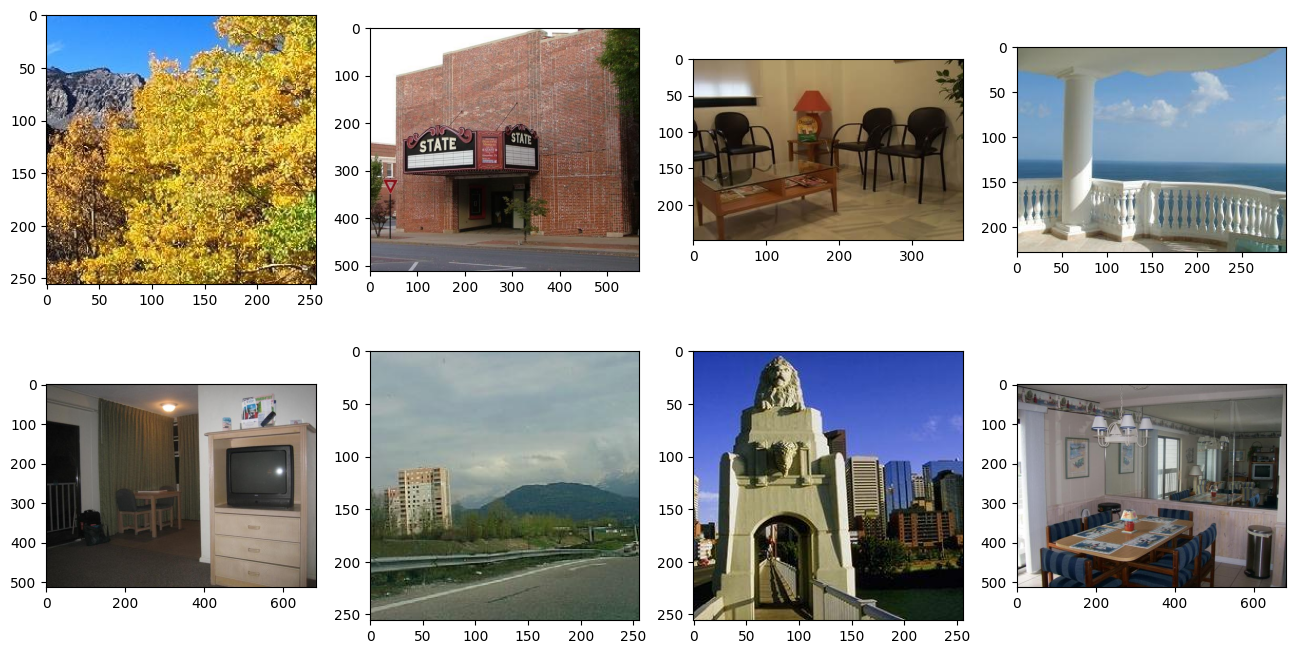

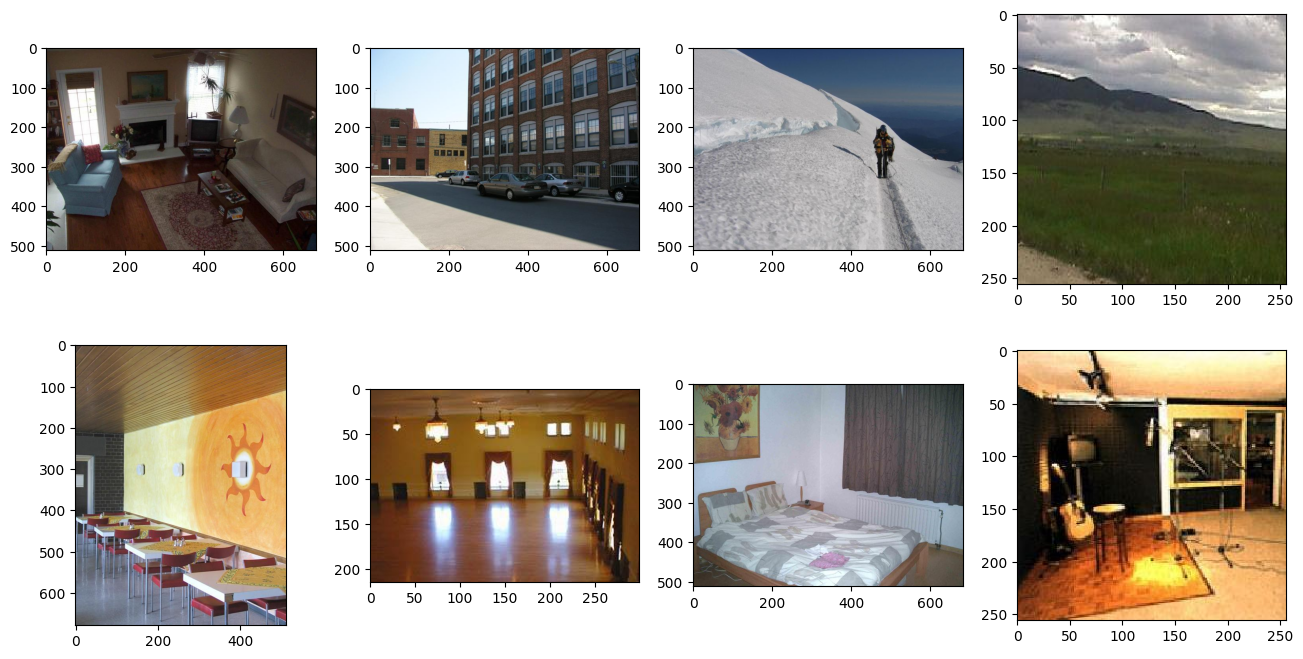

In [9]:
## To Do  : show 8 images from train_loader & 8 images from test_loader
plt.figure(figsize=(16, 8))
for i in range(8):
  plt.subplot(2, 4, i+1)
  plt.imshow(dataset_train[i]['original'].permute(1,2,0))
plt.figure(figsize=(16, 8))
for i in range(8):
  plt.subplot(2, 4, i+1)
  plt.imshow(dataset_test[i]['original'].permute(1,2,0))


##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

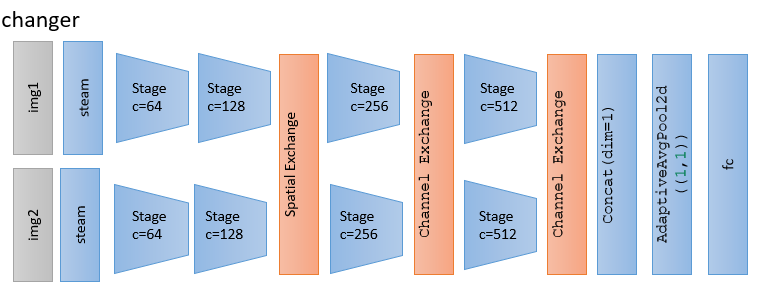

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


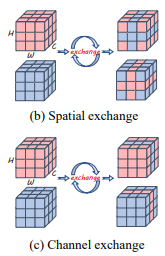

In [10]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

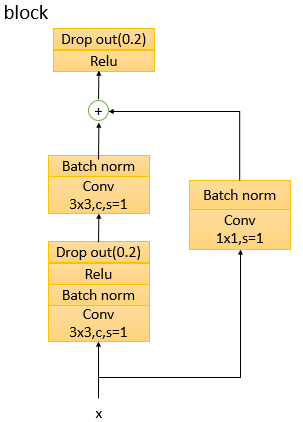

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1)) = 1
 padding(conv) = 1
2.  دلیل استفاده از کانولوشن 1در1 چیست؟

کاهش تعداد کانال‌ها (Dimension Reduction): این لایه برای کاهش تعداد کانال‌ها در مراحل پایانی شبکه استفاده می‌شود و موجب کاهش میزان محاسبات و پارامترها می‌شود.

ترکیب اطلاعات (Feature Combination): کانولوشن1 در 1 برای ترکیب اطلاعات از کانال‌های مختلف و استخراج ویژگی‌های جدید مورد استفاده قرار می‌گیرد.

افزایش انعطاف‌پذیری (Increased Flexibility): این لایه انعطاف‌پذیری شبکه را افزایش می‌دهد و به شبکه این امکان را می‌دهد که با داده‌های متنوع و پیچیده بهتر کار کند.




In [11]:
##To Do
class block(nn.Module):
  def __init__(self,):
    super(block,self).__init__()

    self.path1_conv1 = nn.Conv2d(3, 1, kernel_size=3, stride=1, padding=1)
    self.path1_batchnorm1 = nn.BatchNorm2d(1)
    self.path1_relu1 = nn.ReLU()
    self.path1_dropout1 = nn.Dropout2d(0.2)
    self.path1_conv2 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
    self.path1_batchnorm2 = nn.BatchNorm2d(1)

    self.path2_conv1 = nn.Conv2d(3, 1, kernel_size=1, stride=1)
    self.path2_batchnorm1 = nn.BatchNorm2d(1)

    self.relu = nn.ReLU()
    self.dropout = nn.Dropout2d(0.2)

  def forward(self,x):

    out1 = self.path1_conv1(x)
    out1 = self.path1_batchnorm1(out1)
    out1 = self.path1_relu1(out1)
    out1 = self.path1_dropout1(out1)
    out1 = self.path1_conv2(out1)
    out1 = self.path1_batchnorm2(out1)

    out2 = self.path2_conv1(x)
    out2 = self.path2_batchnorm1(out2)

    out = out1 + out2

    out = self.relu(out)
    out = self.dropout(out)
    return out

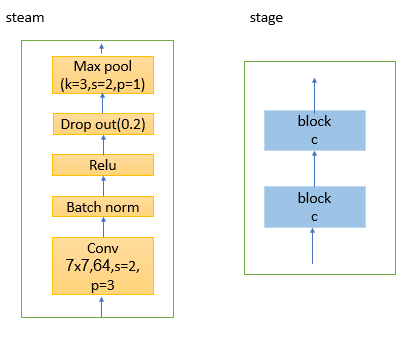

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [12]:
#To Do
class changer(nn.Module):
  def __init__(self,block,SpatialExchange,ChannelExchange):
    super(changer,self).__init__()

    self.steam=nn.Sequential(
          nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Dropout2d(0.2),
          nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    self.stage1= self._make_stage(block)
    self.stage2= self._make_stage(block)
    self.stage3= self._make_stage(block)
    self.stage4= self._make_stage(block)





  def _make_stage(self,):

    layers = [block(), block()]
    return nn.Sequential(*layers)




  def forward(self,x1,x2):

    x1 = SpatialExchange(x1)
    x2 = ChannelExchange(x2)

    x1 = self.stem(x1)
    x2 = self.stem(x2)

    x1 = self.stage1(x1)
    x2 = self.stage2(x2)
    x1 = self.stage3(x1)
    x2 = self.stage4(x2)

    out = x1 + x2

    return out

In [ ]:
## To Do
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model=changer(ResidualBlock,SpatialExchange,ChannelExchange).to(device)

citeration = nn.CrossEntropyLoss() ## loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) ## optimizer

##Train & validation


In [ ]:

Loss_train=[]
Loss_val=[]


    print(f'loss_TRAIN ={Sum_loss:.3f},acc_train={(num_correct_train)},\t loss_val= {loss_val:.3f}, acc_val={(num_correct_val)}')

#Test


In [ ]:
checkpoint = torch.load('#To Do')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

## To Do test
test_loss = 0.0
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = citeration(outputs, labels)

        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

average_test_loss = test_loss / len(test_loader)
accuracy = correct_predictions / total_samples

print(f' loss_test= {:.3f}, acc_test={()}')

سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟